Notebook for training on derived Airspeed. Airspeed is simply $v_{rider} - v_{wind}$.  

Airspeed, as opposed to seperate rider and wind velocity features, is robust to wind speed and direction.

Input features:
Concatenation of 5 time-series datapoints, each having:
- Time delta from previous point (seconds)
- Elevation delta from previous point (meters)
- Airspeed (m/s)

Output labels:
- 5 second power in watts (target)

In [1]:
import datetime
import os
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from wind2watts.data.datasets import AirspeedPowerDataset
from wind2watts.fit.util import fit_to_df

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#### Load Data

In [3]:
activities = []
data_dir = '../../data/dataframes/strava_export/'
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(data_dir, file))
    df['name'] = file.split('.')[0]
    activities.append(df)

#### Construct Datasets

In [4]:
from sklearn.model_selection import train_test_split
train_activities, test_activities = train_test_split(activities, test_size=0.2, random_state=42)

In [5]:
window_size = 5
batch_size = 32

In [6]:
from torch.utils.data import DataLoader

train_dataset = AirspeedPowerDataset(
    train_activities,
    window_size=window_size,
    device=device,
)

val_dataset = AirspeedPowerDataset(
    test_activities,
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
)

test_dataloaders = [DataLoader(AirspeedPowerDataset(
    [activity],
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
), shuffle = False) for activity in test_activities]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, shuffle=False)

len(train_dataloader)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by MinMaxScaler.

#### Define Model

In [42]:
import torch.nn as nn
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
       super(SimpleRNN, self).__init__() 
       self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
       self.fc1 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc1(output[:, -1, :])
        return output

In [43]:
learning_rate = 1e-3 
epochs = 50 

In [44]:
input_size = 3
hidden_size = 32
model = SimpleRNN(input_size = input_size, hidden_size = hidden_size)
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
criterion.to(device)

MSELoss()

In [45]:
model_dir = '../../training_checkpoints/airspeed/simplernn_v0p0/'
os.makedirs(model_dir, exist_ok=True)
min_loss = float('inf')

#### Training Loop

In [46]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    batch_loss = 0
    for i, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = batch_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        val_loss = 0
        for i, (x, y) in enumerate(val_dataloader):
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
    
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pt'))

    print(f'Epoch: {epoch}, Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

Epoch: 0, Loss: 0.014595170176519356, Val Loss: 0.012410837722749944
Epoch: 1, Loss: 0.013983599344010058, Val Loss: 0.012424345316047686
Epoch: 2, Loss: 0.013933012604300984, Val Loss: 0.012873795629815788
Epoch: 3, Loss: 0.01389781933752649, Val Loss: 0.012434903014990069
Epoch: 4, Loss: 0.013861826753935026, Val Loss: 0.012327834161094451
Epoch: 5, Loss: 0.01368484320688548, Val Loss: 0.012074953504956397
Epoch: 6, Loss: 0.013346440166877634, Val Loss: 0.011447337598736283
Epoch: 7, Loss: 0.013124584009775566, Val Loss: 0.011766961499551297
Epoch: 8, Loss: 0.013005644193930492, Val Loss: 0.011379189897575208
Epoch: 9, Loss: 0.012962956478852823, Val Loss: 0.011294793778501393
Epoch: 10, Loss: 0.012956075692842503, Val Loss: 0.011164807391122775
Epoch: 11, Loss: 0.012931593393743288, Val Loss: 0.011341654804229787
Epoch: 12, Loss: 0.012912634365670658, Val Loss: 0.011442495363186237
Epoch: 13, Loss: 0.012893161199427003, Val Loss: 0.011097648408413532
Epoch: 14, Loss: 0.0128798719515

KeyboardInterrupt: 

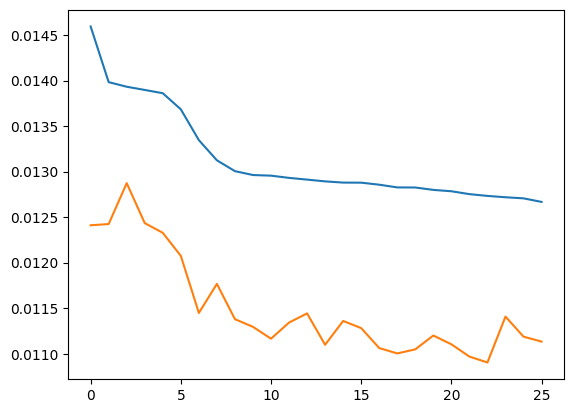

In [48]:
plt.plot(train_losses)
plt.plot(val_losses)

#### Model Eval

In [51]:
best_model = SimpleRNN(input_size, hidden_size) 
best_model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pt')))

<All keys matched successfully>

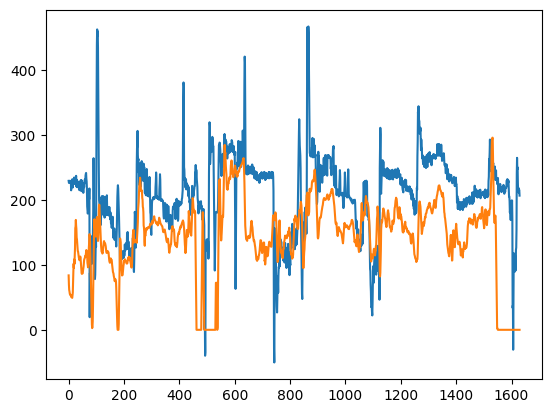

In [64]:
test_activity_dataloader = test_dataloaders[1]

powers = []
pred_powers =  []
for (window, power) in test_activity_dataloader:
    with torch.no_grad():
        power_pred = model(window)
    power_pred = train_dataset.power_scaler.inverse_transform(power_pred.cpu().numpy())
    power = train_dataset.power_scaler.inverse_transform(power.cpu().numpy())
    pred_powers.append(power_pred)
    powers.append(power)

powers = np.array(powers).reshape(-1)
pred_powers = np.array(pred_powers).reshape(-1)


plt.plot(pred_powers, label='Predicted Power')
plt.plot(powers, label='Actual Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')